<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!curl "https://drive.usercontent.google.com/download?id=1YpWIF-tmCFxR2PMplY_tlLWzli8qfvkB&confirm=xxx" -o data/hw2_data.zip
!unzip -o -qq data/hw2_data.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0   112M      0  0:00:02  0:00:02 --:--:--  112M


In [2]:
!pip install ..

Processing /home/ubuntu/Documents/CS294-158
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=42416 sha256=d17d2893135784d879a3173217286e425c19a900432dcc2c3eb8a0314cbb7309
  Stored in directory: /home/ubuntu/.cache/pip/wheels/c4/35/f7/51059a038a194a56ffe68cd93d07d72614887c5129182f6f52
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [3]:
import numpy as np

import torch
from torch.utils.data import DataLoader

from deepul.hw1_helper import train as train_uniloss
from deepul.hw2_helper import (
    train,
    # Q1
    visualize_q1_data,
    q1_save_results,
    # Q2
    visualize_svhn,
    visualize_cifar10,
    q2_save_results,
    # Q3
    q3_save_results,
)

/opt/conda/envs/CS294-158/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from deepul.models.ae import VAE, VAEConv, HVAEConv
from deepul.models.vqvae import VQVAE
from deepul.models.transformer import ImageGPT

from deepul.data.utils import IntDataset

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


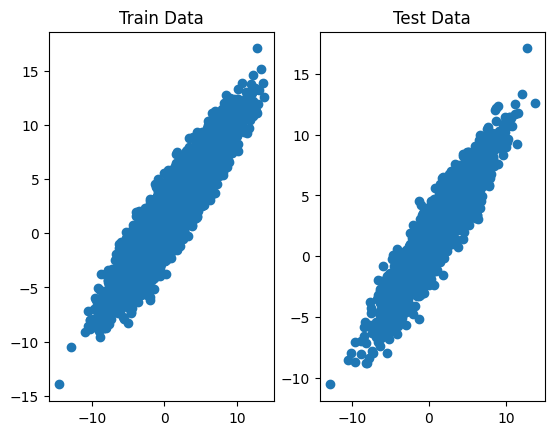

Dataset 2


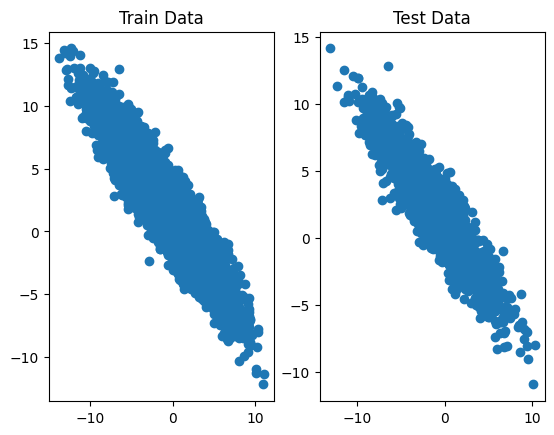

In [5]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [6]:
def q1(train_data, test_data, part, dset_id, n_layers=2, n_hiddens=128, n_samples=1000,
       batch_size=128, epochs=10, lr=1e-3, device=None):
    """
    train_data: An (n_train, n_dims) numpy array of floats
    test_data: An (n_test, n_dims) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
        if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
            used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated after each epoch
    - a numpy array of size (n_samples, n_dims) of n_samples samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (n_samples, n_dims) of n_samples samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    _, n_dims = train_data.shape

    model = VAE(n_dims, n_dims, [n_hiddens]*n_layers, [n_hiddens]*n_layers, loss_reduce="batch").to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, lr=lr, epochs=epochs, quiet=True)

    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kldiv_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kldiv_loss']), axis=1)

    samples_noise = model.generate(size=n_samples, noise=True)
    samples_nonoise = model.generate(size=n_samples, noise=False)
    return train_losses, test_losses, samples_noise, samples_nonoise


### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.4879, Recon Loss: 3.0718, KL Loss: 1.4161


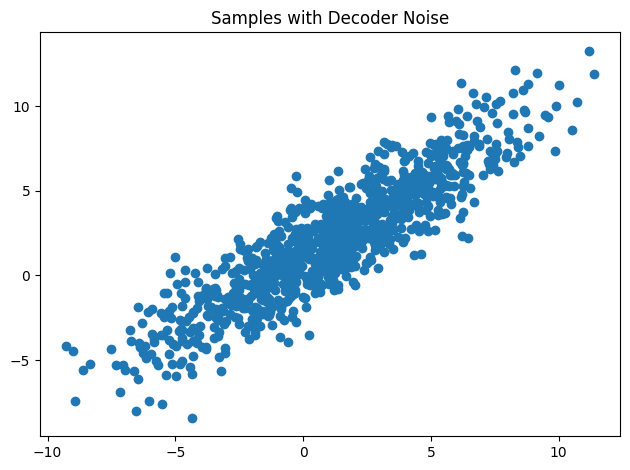

In [7]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.4664, Recon Loss: 3.0492, KL Loss: 1.4172


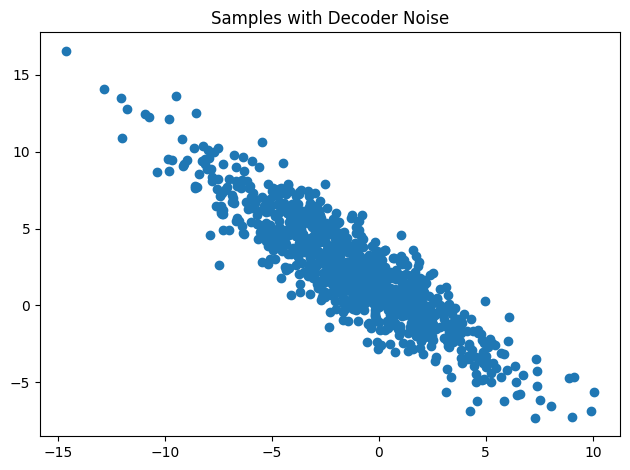

In [23]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


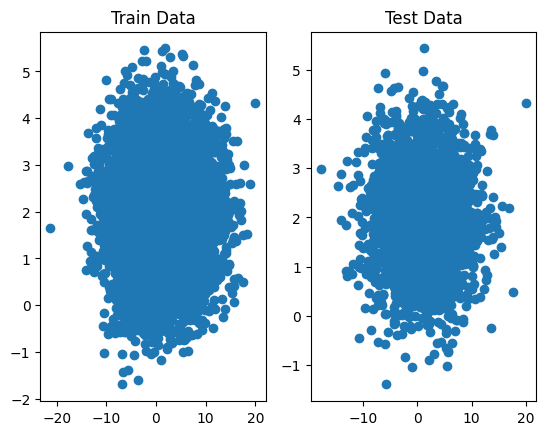

Dataset 2


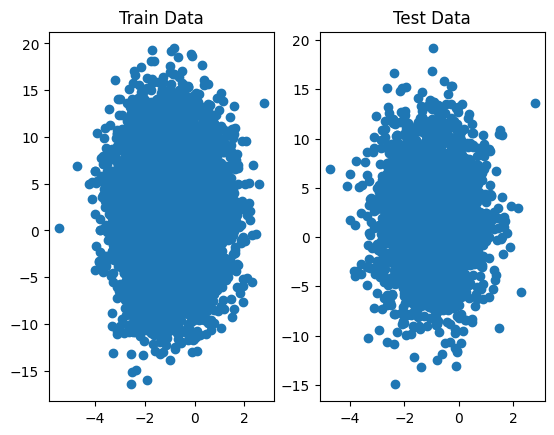

In [24]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

In [8]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4317, Recon Loss: 3.6887, KL Loss: 0.7430


Final -ELBO: 4.4516, Recon Loss: 3.3865, KL Loss: 1.0652


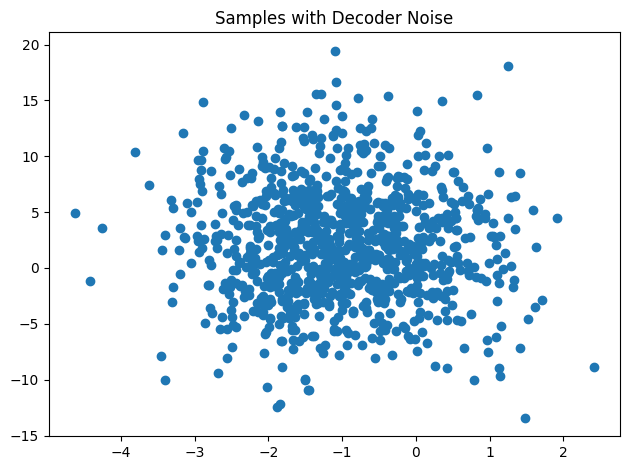

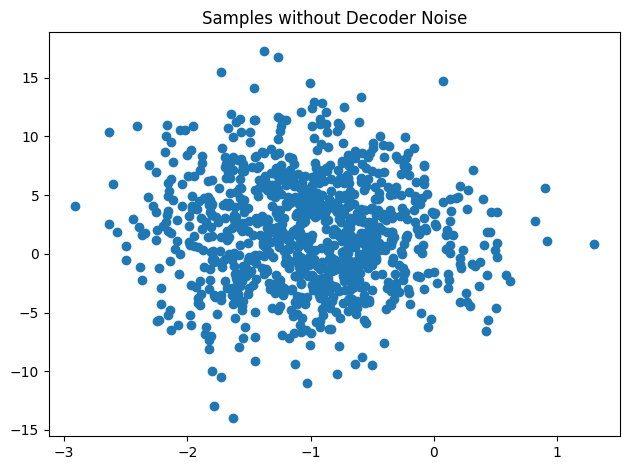

In [9]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without decoder noise in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

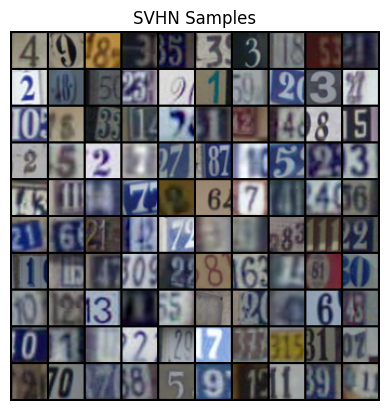

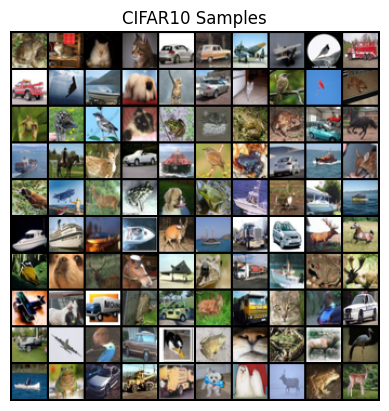

In [5]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
def q2_a(train_data, test_data, dset_id, n_samples=100,
         batch_size=128, epochs=50, lr=1e-3, device=None):
    """
    train_data: An (n_train, H, W, C) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, H, W, C) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated after each epoch
    - a (n_samples, H, W, C) numpy array of n_samples samples from your VAE with values in {0, ..., 255}
    - a (n_samples, H, W, C) numpy array of n_samples/2 real image & reconstruction pairs
        FROM THE TEST SET with values in {0, ..., 255}
    - a (n_samples, H, W, C) numpy array of n_samples/10 interpolations of length 10 between
        pairs of test images. The output should be those n_samples images flattened into
        the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data = torch.FloatTensor(np.transpose(train_data, (0, 3, 1, 2)) / 255. * 2 - 1)
    test_data = torch.FloatTensor(np.transpose(test_data, (0, 3, 1, 2)) / 255. * 2 - 1)
    _, c, h, w = train_data.shape

    model = VAEConv(input_dim=c, input_res=(h,w), latent_dim=1024, latent_res=(1,1),
        enc_hidden_sizes=[32, 64, 128, 256, 512], enc_hidden_reses=[(h,w), (h//2,w//2), (h//4,w//4), (h//8,w//8), (1,1)],
        dec_hidden_sizes=[512, 256, 128, 64, 32], dec_hidden_reses=[(1,1), (h//8,w//8), (h//4,w//4), (h//2,w//2), (h,w)],
        loss_reduce="batch"
    ).to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, lr=lr, epochs=epochs, quiet=True)

    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kldiv_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kldiv_loss']), axis=1)

    # sample
    samples = model.generate(size=n_samples)
    samples = np.transpose(samples, (0, 2, 3, 1))
    # reconstruct
    reals = test_data[np.random.choice(len(test_data), n_samples//2)]
    recons = model.predict(reals)
    pairs = np.transpose(np.reshape(np.stack((reals.numpy(), recons), axis=1), (-1, c, h, w)), (0, 2, 3, 1))
    # interpolate
    parents = test_data[np.random.choice(len(test_data), n_samples//10*2)].chunk(2, dim=0)
    interps = model.interpolate(*parents, n_interps=10)
    interps = np.transpose(np.reshape(np.stack(interps, axis=1), (-1, c, h, w)), (0, 2, 3, 1))

    return train_losses, test_losses, (samples+1)/2*255, (pairs+1)/2*255, (interps+1)/2*255

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 127.4972, Recon Loss: 108.3989, KL Loss: 19.0984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


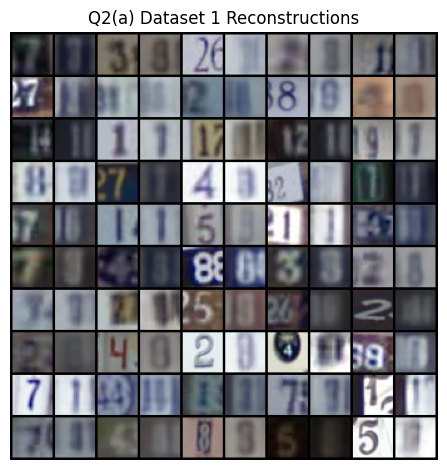

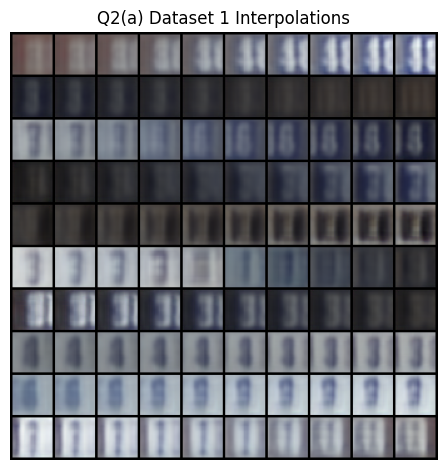

In [6]:
q2_save_results('a', 1, q2_a)

Final -ELBO: 219.6504, Recon Loss: 180.4849, KL Loss: 39.1655


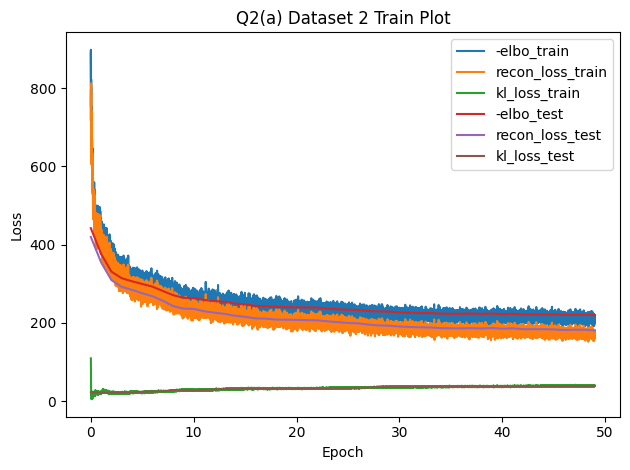

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


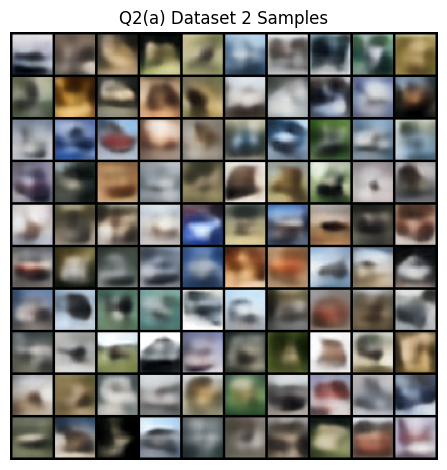

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


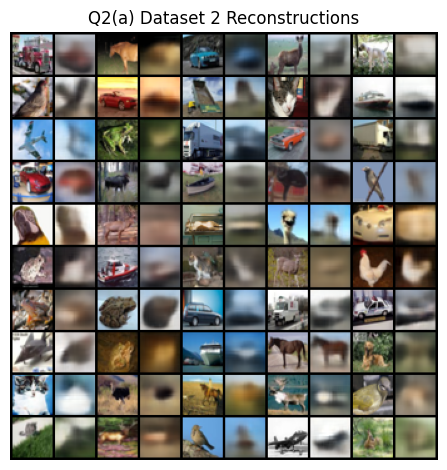

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


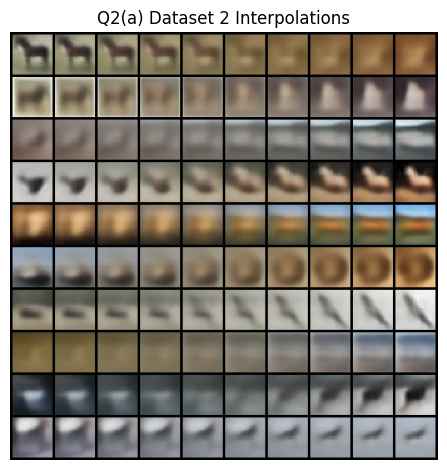

In [7]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [7]:
def q2_b(train_data, test_data, dset_id, n_samples=100,
         batch_size=128, epochs=50, lr=1e-3, device=None):
    """
    train_data: An (n_train, H, W, C) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, H, W, C) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated after each epoch
    - a (n_samples, H, W, C) numpy array of n_samples samples from your VAE with values in {0, ..., 255}
    - a (n_samples, H, W, C) numpy array of n_samples/2 real image & reconstruction pairs
        FROM THE TEST SET with values in {0, ..., 255}
    - a (n_samples, H, W, C) numpy array of n_samples/10 interpolations of length 10 between
        pairs of test images. The output should be those n_samples images flattened into
        the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data = torch.FloatTensor(np.transpose(train_data, (0, 3, 1, 2)) / 255. * 2 - 1)
    test_data = torch.FloatTensor(np.transpose(test_data, (0, 3, 1, 2)) / 255. * 2 - 1)
    _, c, h, w = train_data.shape

    model = HVAEConv(input_dim=c, input_res=(h,w), latent_dim=1024, latent_res=(1,1),
        enc_hidden_sizes=[32, 64, 128, 256, 512],
        enc_hidden_reses=[(h,w), (h//2,w//2), (h//4,w//4), (h//8,w//8), (1,1)],
        n_levels=2, loss_reduce="batch"
    ).to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, lr=lr, epochs=epochs, quiet=True)

    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kldiv_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kldiv_loss']), axis=1)

    # sample
    samples = model.generate(size=n_samples)
    samples = np.transpose(samples, (0, 2, 3, 1))
    # reconstruct
    reals = test_data[np.random.choice(len(test_data), n_samples//2)]
    recons = model.predict(reals)
    pairs = np.transpose(np.reshape(np.stack((reals.numpy(), recons), axis=1), (-1, c, h, w)), (0, 2, 3, 1))
    # interpolate
    parents = test_data[np.random.choice(len(test_data), n_samples//10*2)].chunk(2, dim=0)
    interps = model.interpolate(*parents, n_interps=10)
    interps = np.transpose(np.reshape(np.stack(interps, axis=1), (-1, c, h, w)), (0, 2, 3, 1))

    return train_losses, test_losses, (samples+1)/2*255, (pairs+1)/2*255, (interps+1)/2*255

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 92.9405, Recon Loss: 56.4327, KL Loss: 36.5078


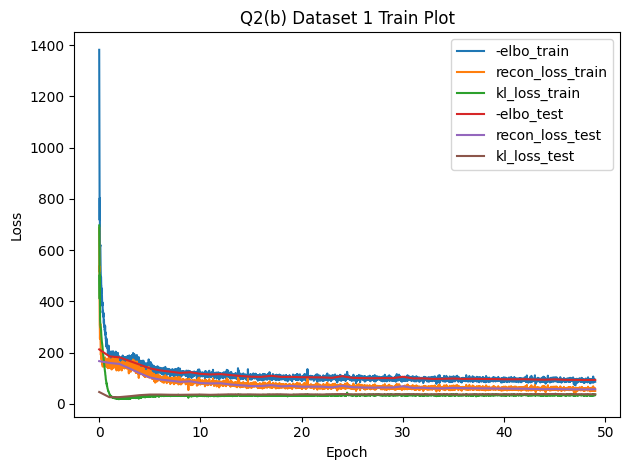

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


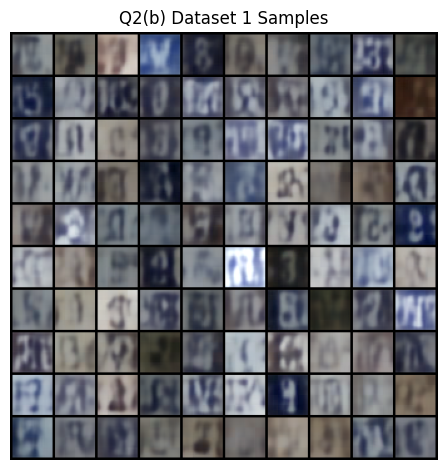

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


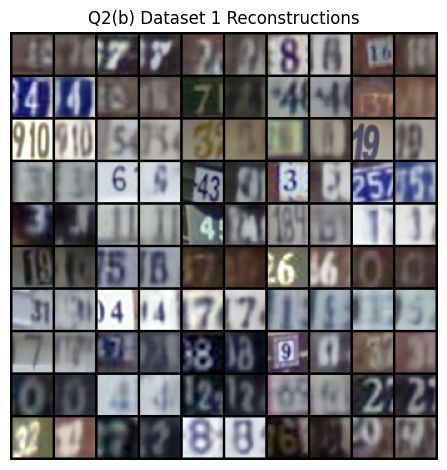

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


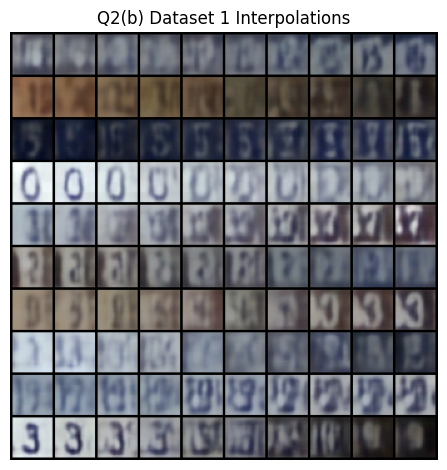

In [8]:
q2_save_results('b', 1, q2_b)

Final -ELBO: 186.8542, Recon Loss: 124.9074, KL Loss: 61.9468


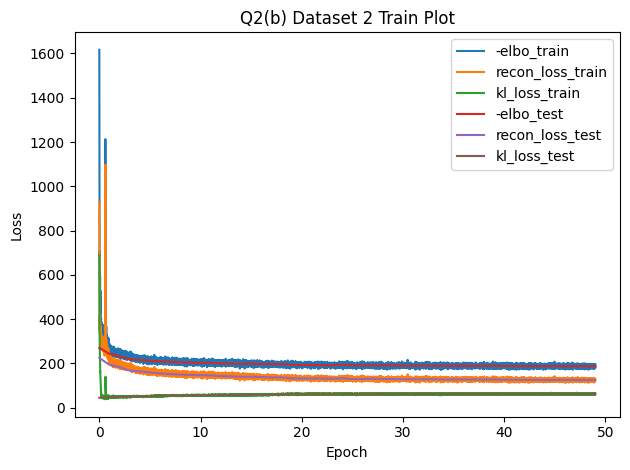

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


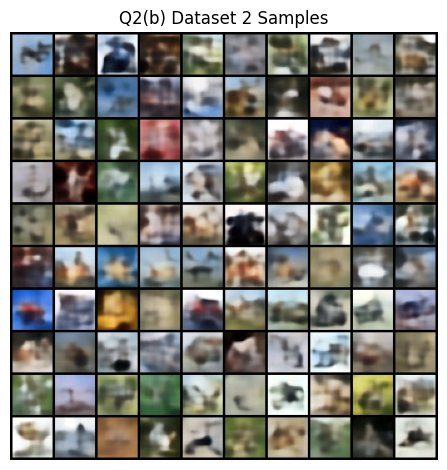

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


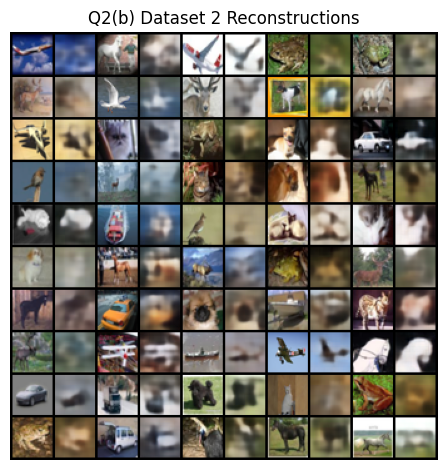

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


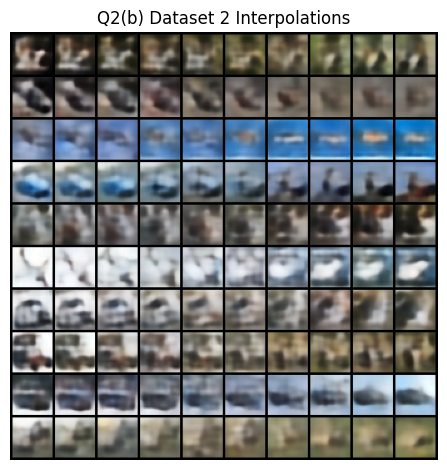

In [9]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you will train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
def q3(train_data, test_data, dset_id, n_samples=100, batch_size=128, epochs=50, lr=1e-3,
       prior_batch_size=64, prior_epochs=30, prior_lr=1e-3, device=None):
    """
    train_data: An (n_train, H, W, C) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, H, W, C) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs,) numpy array of VQ-VAE test losses evaluated after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (n_samples, H, W, C) numpy array of n_samples samples with values in {0, ... 255}
    - a (n_samples, H, W, C) numpy array of n_samples/2 real image & reconstruction pairs
        FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    # model
    train_data = torch.FloatTensor(train_data / 255.)
    test_data = torch.FloatTensor(test_data / 255.)
    _, h, w, c = train_data.shape

    model = VQVAE(h_dim=256, res_h_dim=32, n_res_layers=3, n_embeddings=1024, embedding_dim=64, min_val=0, max_val=1).to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, lr=lr, epochs=epochs, quiet=True)

    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kldiv_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kldiv_loss']), axis=1)

    model = model.to("cpu")
    # prior
    prior_train_data = model.quantize(train_data)[:, None, :, :]
    prior_test_data = model.quantize(test_data)[:, None, :, :]
    _, prior_c, prior_h, prior_w = prior_train_data.shape

    prior_model = ImageGPT((prior_c, prior_h, prior_w), model.n_embeddings, d_model=128, n_layers=4, n_heads=4).to(device)
    prior_train_loader = DataLoader(IntDataset(prior_train_data), batch_size=prior_batch_size, shuffle=True)
    prior_test_loader = DataLoader(IntDataset(prior_test_data), batch_size=prior_batch_size)
    prior_train_losses, prior_test_losses = train_uniloss(prior_model, prior_train_loader, prior_test_loader, lr=prior_lr, epochs=prior_epochs, quiet=True)

    model = model.to(device)
    # sample
    samples = prior_model.sample(n_samples, kv_cache=True)
    samples = model.decode(samples[:, 0, :, :])
    # reconstruct
    reals = test_data[np.random.choice(len(test_data), n_samples//2)]
    recons = model.predict(reals)
    pairs = np.reshape(np.stack((reals.numpy(), recons), axis=1), (-1, h, w, c))

    return train_losses, test_losses, prior_train_losses, prior_test_losses, samples*255, pairs*255

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0020, Recon Loss: 0.0015, Emb Loss: 0.0005
Transformer Prior Final Test Loss: 4.2370


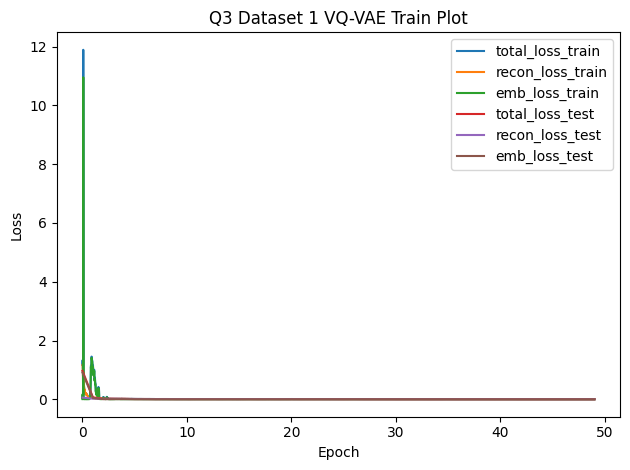

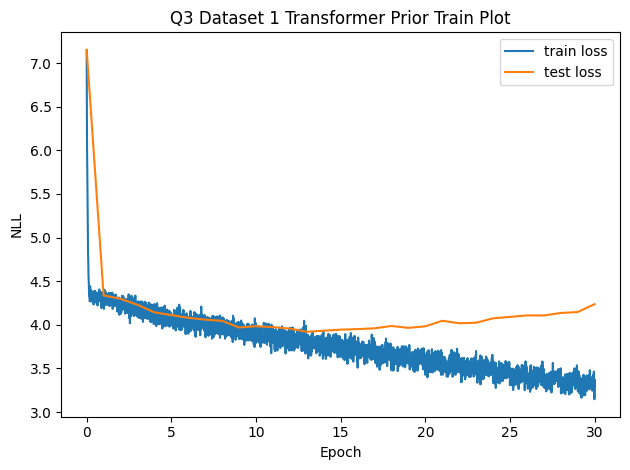

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


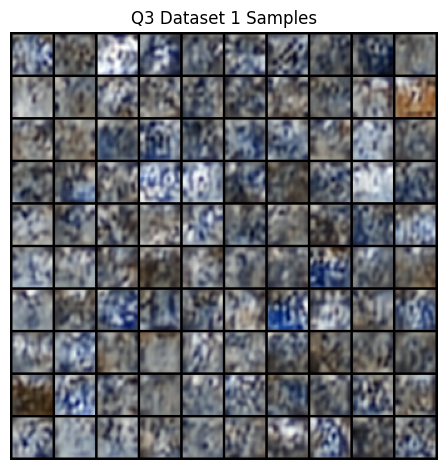

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


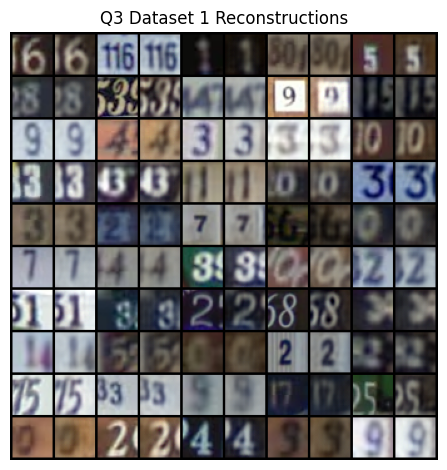

In [8]:
q3_save_results(1, q3)

VQ-VAE Final Test Loss: 0.0064, Recon Loss: 0.0042, Emb Loss: 0.0021
Transformer Prior Final Test Loss: 4.9315


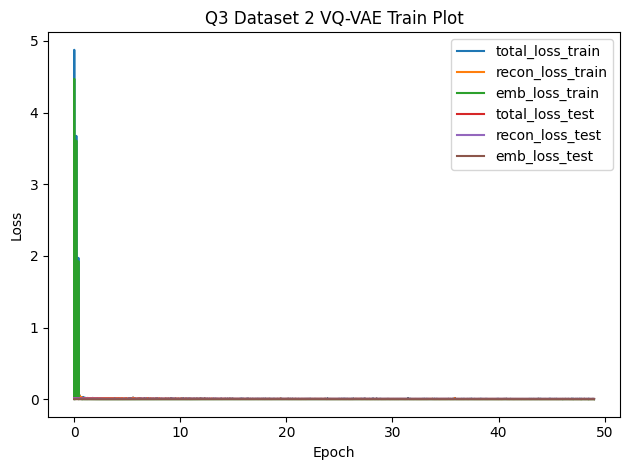

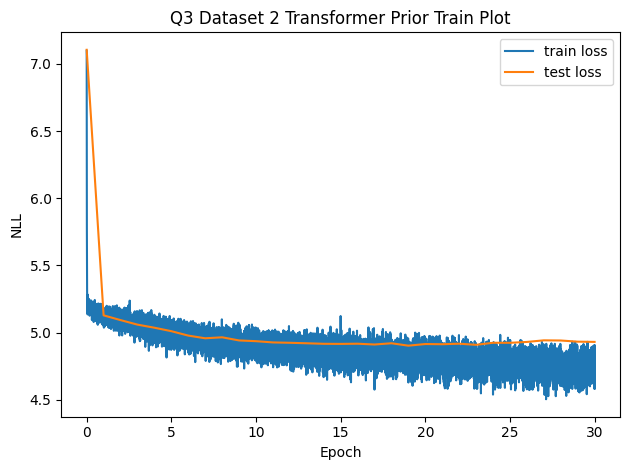

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


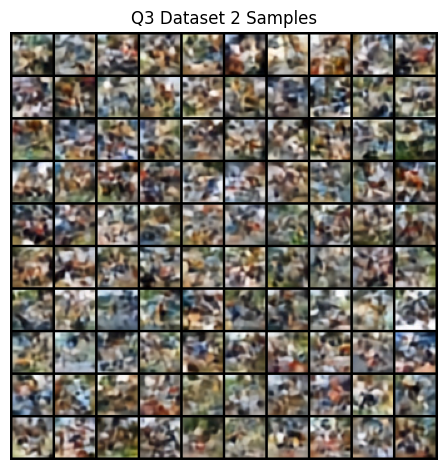

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


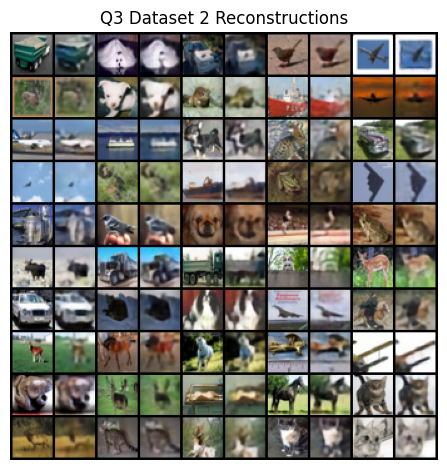

In [7]:
q3_save_results(2, q3)